In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36619,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:44983,Total threads: 4
Dashboard: /proxy/33183/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:36907,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [53]:
uas = xr.open_dataset('../data/uas-monthly-1979_2015-cmip6.nc').sel(time = slice('1979-01-01', '2015-01-01'))['uas']
vas = xr.open_dataset('../data/vas-monthly-1979_2015-cmip6.nc').sel(time = slice('1979-01-01', '2015-01-01'))['vas']

In [4]:
uas_ssp45 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp45.nc')['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
vas_ssp45 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp45.nc')['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

uas_ssp85 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
vas_ssp85 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

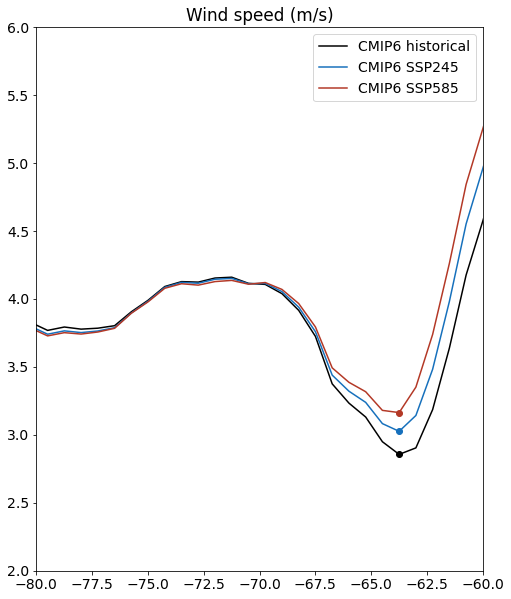

In [105]:
plt.figure(figsize = (8,10))
plt.plot(uas['lat'], np.sqrt(uas**2 + vas**2).mean('time').mean('lon'), color = 'k', label = 'CMIP6 historical')
plt.plot(uas_ssp45['lat'], np.sqrt(uas_ssp45**2 + vas_ssp45**2).mean('time').mean('lon'), color = cmocean.cm.balance(.2), label = 'CMIP6 SSP245')
plt.plot(uas_ssp85['lat'], np.sqrt(uas_ssp85**2 + vas_ssp85**2).mean('time').mean('lon'), color = cmocean.cm.balance(.8), label = 'CMIP6 SSP585')
plt.xlim(-80, -60)
plt.ylim(2,6)
plt.scatter(uas.sel(lat = slice(-80, -60))['lat'][np.sqrt(uas**2 + vas**2).mean('time').mean('lon').sel(lat = slice(-80, -60)).argmin()], 
            np.sqrt(uas**2 + vas**2).mean('time').mean('lon').sel(lat = slice(-80, -60)).min(), c = 'k')
plt.scatter(uas_ssp45.sel(lat = slice(-80, -60))['lat'][np.sqrt(uas_ssp45**2 + vas_ssp45**2).mean('time').mean('lon').sel(lat = slice(-80, -60)).argmin()], 
            np.sqrt(uas_ssp45**2 + vas_ssp45**2).mean('time').mean('lon').sel(lat = slice(-80, -60)).min(), color = cmocean.cm.balance(.2))
plt.scatter(uas_ssp85.sel(lat = slice(-80, -60))['lat'][np.sqrt(uas_ssp85**2 + vas_ssp85**2).mean('time').mean('lon').sel(lat = slice(-80, -60)).argmin()], 
            np.sqrt(uas_ssp85**2 + vas_ssp85**2).mean('time').mean('lon').sel(lat = slice(-80, -60)).min(), color = cmocean.cm.balance(.8))
plt.legend();
plt.title('Wind speed (m/s)')
plt.savefig('fig-for-martin3.jpg', bbox_inches = 'tight')

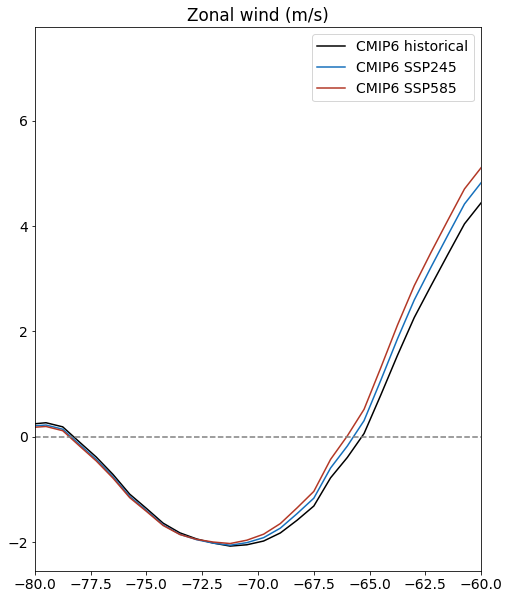

In [106]:
plt.rcParams['font.size'] = 14
plt.figure(figsize = (8,10))
plt.plot(uas['lat'], uas.mean('time').mean('lon'), color = 'k', label = 'CMIP6 historical')
plt.plot(uas_ssp45['lat'], uas_ssp45.mean('time').mean('lon'), color = cmocean.cm.balance(.2), label = 'CMIP6 SSP245')
plt.plot(uas_ssp85['lat'], uas_ssp85.mean('time').mean('lon'), color = cmocean.cm.balance(.8), label = 'CMIP6 SSP585')
plt.xlim(-80, -60)
plt.axhline(y = 0, linestyle = '--', color = 'grey')
plt.legend()
plt.title('Zonal wind (m/s)')
plt.savefig('fig-for-martin2.jpg', bbox_inches = 'tight')

In [57]:
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']
hu = hu.sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90,-50.1,.1))), 1, np.nan)
land_ice_mask = land_ice_mask.interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, 
                                     land_ice_mask['lon'] + 360, 
                                     land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon':'_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj':sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj':'lon'})

In [54]:
uwh, lon = add_cyclic_point(uas.sel(time = slice('2005-01-01', '2015-01-01')).mean('time'), coord = uas['lon'].values)
uwp, lon = add_cyclic_point(uas_ssp85.sel(time = slice('2015-01-01', '2100-01-01')).mean('time'), coord = uas_ssp85['lon'].values)

In [55]:
div_line_hist = xr.open_dataarray('div_line_2005-2015-cmip6.nc')
div_line_proj = xr.open_dataarray('div_line_2015-2100-cmip6.nc')

In [59]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [96]:
from matplotlib.lines import Line2D

In [102]:
legend_elements = [Line2D([0], [0], color = 'lime', lw = 3, label = 'Zero zonal wind line SSP585'),
                   Line2D([0], [0], color = 'm', lw = 3, label = 'Zero zonal wind line historical'),
                   Line2D([0], [0], color = 'darkorange', lw = 3, label = 'Min. wind speed line historical'),
                   Line2D([0], [0], color = 'b', lw = 2, label = 'Min. wind speed line SSP585')]

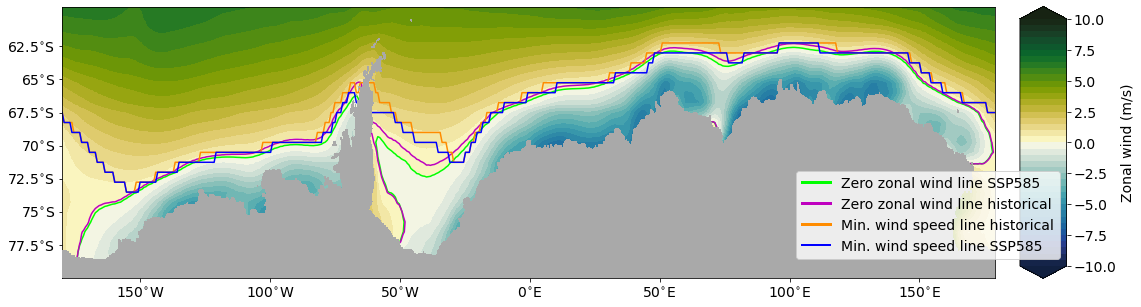

In [103]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 5))
gr = gs.GridSpec(1, 2, figure = fig, width_ratios = [1,.05], 
                 hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1])]
axs[0].set_xlim([-180, 179.25])
axs[0].set_ylim([-80, -59.5])
axs[0].set_yticks(np.arange(-77.5, -60, 2.5))
axs[0].set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
axs[0].set_xticks(np.arange(-150, 200, 50))
axs[0].set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                        '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
axs[0].contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
cf = axs[0].contourf(lon, uas['lat'], uwp, levels = np.arange(-10, 10.5, .5), cmap = cmocean.cm.delta, extend = 'both',
                  zorder = 0)
plt.colorbar(cf, cax = axs[1], fraction = .02).set_label('Zonal wind (m/s)')
axs[0].contour(lon, uas['lat'], uwp, levels = [0], colors = ['lime'], label = 'Zero zonal wind line SSP585')
axs[0].contour(lon, uas['lat'], uwh, levels = [0], colors = ['m'], label = 'Zero zonal wind line historical')
axs[0].plot(div_line_hist['lon'], div_line_hist, color = 'darkorange', label = 'Zero wind speed line historical')
axs[0].plot(div_line_proj['lon'], div_line_proj, color = 'b', label = 'Zero wind speed line SSP585')
plt.legend(handles = legend_elements, loc = 'lower right')
plt.savefig('fig-for-martin-1.jpg', bbox_inches = 'tight')